In [2]:
import torch
import torchvision
import os
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
# from torchvision.io import read_image
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import time
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import copy
from tqdm import tqdm
from collections import Counter
import random
import csv
import pandas as pd
from torchsummary import summary

In [3]:
class ImageFolderDataset(Dataset):
    def __init__(self, img_dir):
        self.img_dir = img_dir
        self.img_files_list = [s for s in os.listdir(img_dir)]
        self.transform = transforms.Compose([
                                                transforms.Resize(256),
                                                transforms.CenterCrop(224),
                                                transforms.ToTensor(),
                                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                           ])
        self.label_transform = transforms.ToTensor()
    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.img_files_list[idx])
        image = Image.open(img_name)
#         image = self.transform(image)
        label = int(self.img_files_list[idx].split("_")[0])
        sample = {"image": image, "label": label}
        return image, label
    
    def __len__(self):
        return len(self.img_files_list)
    
    def transform(self, transform):
        self.transform = transform

class CSVDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.targets = self.img_labels.iloc[:, 1]
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = Image.open(img_path)
        if image.mode != 'RGB':
            image = image.convert('RGB')
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        return image, label

    def __len__(self):
        return len(self.img_labels)

In [4]:
train_transform = transforms.Compose([
                                        transforms.RandomResizedCrop(224),
                                        # transforms.CenterCrop(512),
                                        transforms.Resize([224, 224]),
                                        #transforms.RandomResizedCrop(512),
                                        # transforms.Resize(256),
                                        # transforms.CenterCrop(224),
                                        # transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0),
                                        # transforms.Randomapply([transforms.Colorjitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0)], p=0.5)
                                        transforms.RandomHorizontalFlip(),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                       ])

test_transform = transforms.Compose([
                                        transforms.Resize(224),
                                        #transforms.CenterCrop(512),
                                        transforms.Resize([224, 224]),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                       ])

In [5]:
# Load the images to Self defined Dataset
#train_set = CSVDataset('ysq_traindata.csv', 'train_ysq', train_transform)
#test_set = CSVDataset('val.csv', 'data/A', test_transform)
train_set = CSVDataset('ysq_train500.csv', 'joint_train',train_transform)
test_set = CSVDataset('ysq_test500.csv', 'joint_test',test_transform)
#print(train_set.targets)
# Weighted Random Sampler for imbalanced dataset
class_weights = [1/i for i in dict(Counter(train_set.targets)).values()]
weights = [class_weights[int(i)] for i in train_set.targets]
sampler = torch.utils.data.WeightedRandomSampler(weights, len(weights), replacement=True)

#train_loader = torch.utils.data.DataLoader(train_set, batch_size=16, shuffle=True, num_workers=5, pin_memory=True)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, num_workers=5, pin_memory=False)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=True, num_workers=5, pin_memory=False)
dataset_sizes = {'train': len(train_set), 'test': len(test_set)}
dataloaders = {'train': train_loader, 'test': test_loader}
print(dataset_sizes, dataloaders)

{'train': 3518, 'test': 14072} {'train': <torch.utils.data.dataloader.DataLoader object at 0x7fb092b46f98>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x7fb146381f60>}


In [6]:
# os.environ['CUDA_VISIBLE_DEVICES'] = '1,'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
print(device)
torch.cuda.set_device(0)
print(torch.cuda.current_device())
# if output_device is None:
#     output_device =device_ids[1]

cuda:0
0


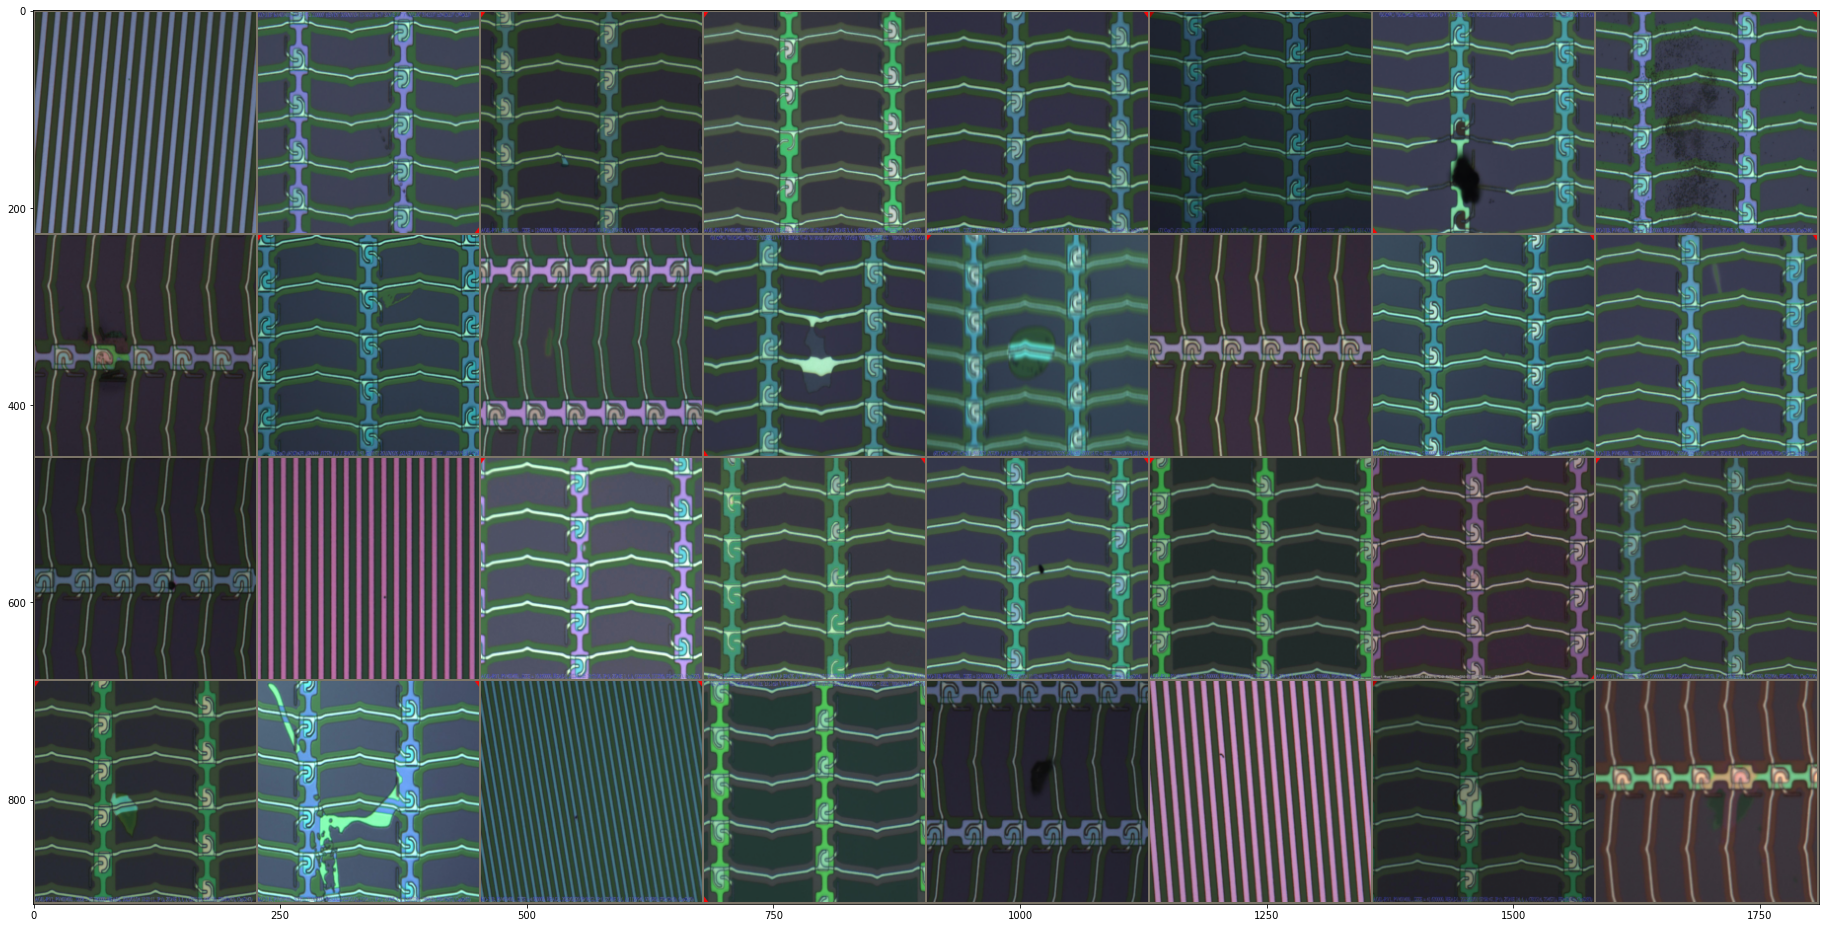

In [7]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize = (32,32))
    plt.imshow(inp)
#     if title is not None:
#         plt.title(title)
    
    
#     plt.pause(0.001)  # pause a bit so that plots are updated
    
    plt.savefig('imshow_crop.png')


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[int(x) for x in classes])

In [8]:
def draw_loss(loss_metrics, acc_metrics, last):
    xx = range(0, len(loss_metrics['train']))
    
    ax1 = plt.subplot(1, 2, 1)
    plt.sca(ax1)
    plt.plot(xx, loss_metrics['train'], "r", label="train_loss")
    plt.plot(xx, loss_metrics['test'], "b", label="valid_loss")
    plt.legend()
    
    ax2 = plt.subplot(1, 2, 2)
    plt.sca(ax2)
    plt.plot(xx, acc_metrics['train'], "y", label="train_acc")
    plt.plot(xx, acc_metrics['test'], "g", label="valid_acc")
    plt.legend()
    
    #if last:
        #plt.savefig('./AUO_Joint_training/35/Images/Metric_Incrementl_ResNet18_Adam_lr_1e-3_balanced.png')
        
    plt.show()

In [9]:
def train(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    
    loss_metrics = {}
    acc_metrics = {}
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs-1))
        print("-" * 10)
        
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            running_loss = 0.0
            running_corrects = 0
            
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
#                     if phase == 'train':
#                         outputs, aux_logits2, aux_logits1 = model(inputs)
#                     else:
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, dim=1)
#                     print(outputs)
#                     if phase == 'train':
#                         loss = criterion(outputs, labels)
#                         loss += criterion(aux_logits1, labels) * 0.3
#                         loss += criterion(aux_logits2, labels) * 0.3
#                     else:
                    labels = labels.to(torch.int64)  #转换为int类型----------------------xcs
                    loss = criterion(outputs, labels)
                    
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            if phase not in loss_metrics:
                loss_metrics[phase] = list()
            loss_metrics[phase].append(epoch_loss)
            
            if phase not in acc_metrics:
                acc_metrics[phase] = list()
            acc_metrics[phase].append(epoch_acc.cpu())
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
        if epoch == num_epochs-1:
            last = True
        else:
            last = False
            
        draw_loss(loss_metrics, acc_metrics, last)
    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    return model, loss_metrics, acc_metrics

In [10]:
num_classes = 34
epochs = 300
# model_ft = torchvision.models.googlenet(num_classes = num_classes, aux_logits=True, init_weights=True, pretrained=False)
# model_ft = torchvision.models.efficientnet_b4(pretrained=True)
model_ft = torchvision.models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# num_ftrs = model_ft.classifier[1].in_features

# print(num_ftrs)
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, num_classes)
# model_ft.classifier[1] = nn.Linear(num_ftrs, num_classes)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_ft.parameters(), lr=1e-3, weight_decay=0.0005)
# optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0005)
# torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

exp_lr_scheduler = lr_scheduler.CosineAnnealingLR(optimizer_ft, epochs)

In [11]:
# print(model_ft.fc.in_features)
print(model_ft)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [12]:
summary(model_ft, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

Epoch 0/299
----------


100%|██████████| 110/110 [00:17<00:00,  6.13it/s]


train Loss: 2.9476 Acc: 0.1939


100%|██████████| 440/440 [01:07<00:00,  6.55it/s]


test Loss: 5.0565 Acc: 0.1430


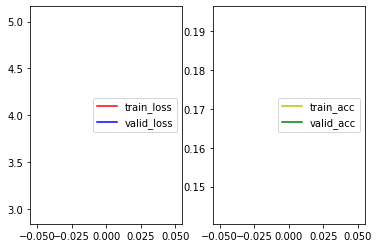

Epoch 1/299
----------


100%|██████████| 110/110 [00:17<00:00,  6.18it/s]


train Loss: 2.2579 Acc: 0.3141


100%|██████████| 440/440 [01:05<00:00,  6.70it/s]


test Loss: 3.1135 Acc: 0.2150


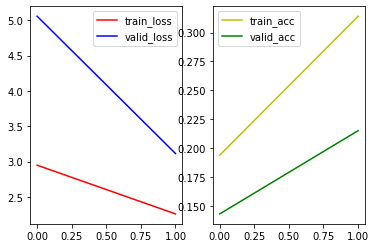

Epoch 2/299
----------


100%|██████████| 110/110 [00:17<00:00,  6.28it/s]


train Loss: 1.9570 Acc: 0.4005


100%|██████████| 440/440 [01:05<00:00,  6.69it/s]


test Loss: 3.0137 Acc: 0.2944


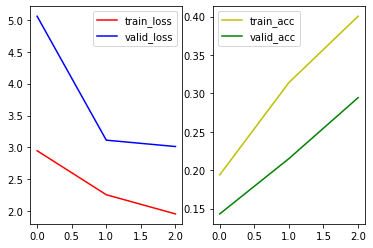

Epoch 3/299
----------


100%|██████████| 110/110 [00:17<00:00,  6.24it/s]


train Loss: 1.7185 Acc: 0.4562


100%|██████████| 440/440 [01:05<00:00,  6.69it/s]


test Loss: 3.6880 Acc: 0.2594


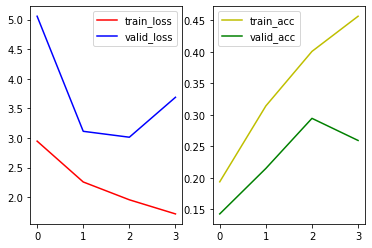

Epoch 4/299
----------


100%|██████████| 110/110 [00:17<00:00,  6.23it/s]


train Loss: 1.5817 Acc: 0.5011


100%|██████████| 440/440 [01:05<00:00,  6.70it/s]


test Loss: 3.5079 Acc: 0.2799


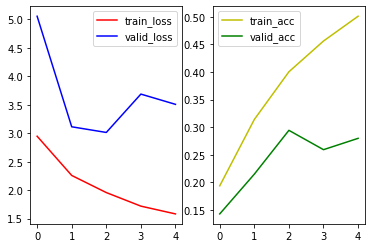

Epoch 5/299
----------


100%|██████████| 110/110 [00:17<00:00,  6.14it/s]


train Loss: 1.3691 Acc: 0.5620


100%|██████████| 440/440 [01:06<00:00,  6.65it/s]


test Loss: 2.5960 Acc: 0.3550


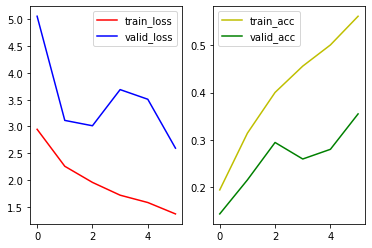

Epoch 6/299
----------


100%|██████████| 110/110 [00:17<00:00,  6.20it/s]


train Loss: 1.1810 Acc: 0.6219


100%|██████████| 440/440 [01:05<00:00,  6.69it/s]


test Loss: 2.7523 Acc: 0.3318


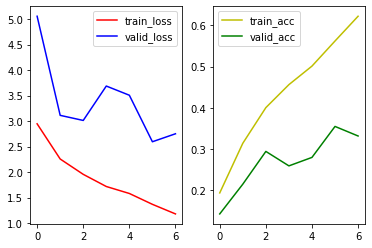

Epoch 7/299
----------


100%|██████████| 110/110 [00:17<00:00,  6.20it/s]


train Loss: 0.9948 Acc: 0.6754


100%|██████████| 440/440 [01:06<00:00,  6.66it/s]


test Loss: 2.5869 Acc: 0.3821


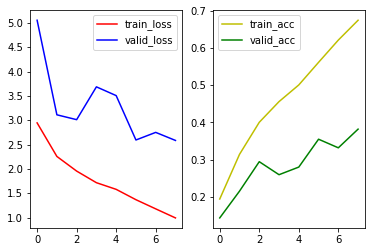

Epoch 8/299
----------


100%|██████████| 110/110 [00:17<00:00,  6.22it/s]


train Loss: 0.8601 Acc: 0.7152


100%|██████████| 440/440 [01:06<00:00,  6.64it/s]


test Loss: 2.4791 Acc: 0.4117


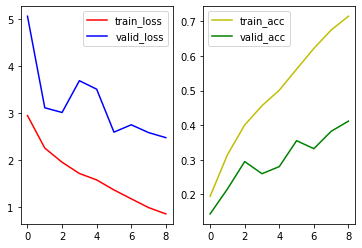

Epoch 9/299
----------


100%|██████████| 110/110 [00:17<00:00,  6.18it/s]


train Loss: 0.7268 Acc: 0.7669


100%|██████████| 440/440 [01:05<00:00,  6.73it/s]


test Loss: 2.5393 Acc: 0.3891


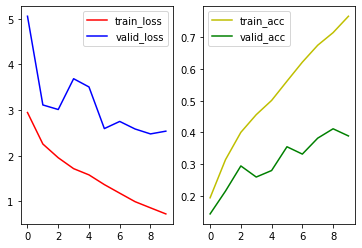

Epoch 10/299
----------


100%|██████████| 110/110 [00:17<00:00,  6.20it/s]


train Loss: 0.6528 Acc: 0.7882


100%|██████████| 440/440 [01:06<00:00,  6.66it/s]


test Loss: 2.1648 Acc: 0.4402


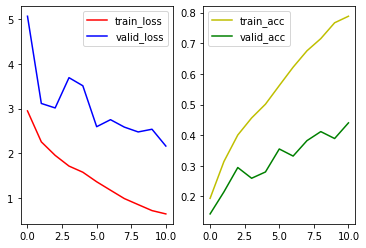

Epoch 11/299
----------


100%|██████████| 110/110 [00:17<00:00,  6.21it/s]


train Loss: 0.5591 Acc: 0.8232


100%|██████████| 440/440 [01:05<00:00,  6.68it/s]


test Loss: 2.7656 Acc: 0.4016


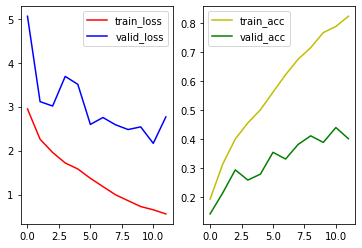

Epoch 12/299
----------


100%|██████████| 110/110 [00:17<00:00,  6.22it/s]


train Loss: 0.5176 Acc: 0.8354


100%|██████████| 440/440 [01:05<00:00,  6.71it/s]


test Loss: 2.4395 Acc: 0.4449


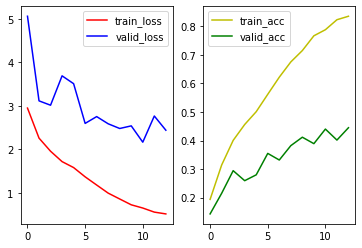

Epoch 13/299
----------


100%|██████████| 110/110 [00:17<00:00,  6.18it/s]


train Loss: 0.4729 Acc: 0.8468


100%|██████████| 440/440 [01:05<00:00,  6.67it/s]


test Loss: 2.7049 Acc: 0.3842


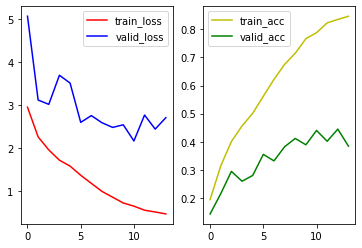

Epoch 14/299
----------


100%|██████████| 110/110 [00:17<00:00,  6.25it/s]


train Loss: 0.4117 Acc: 0.8729


100%|██████████| 440/440 [01:05<00:00,  6.69it/s]


test Loss: 2.5094 Acc: 0.4348


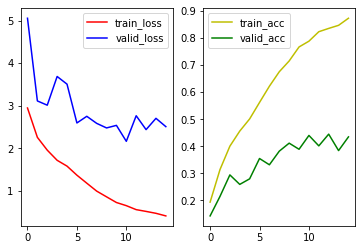

Epoch 15/299
----------


100%|██████████| 110/110 [00:17<00:00,  6.19it/s]


train Loss: 0.3149 Acc: 0.9062


100%|██████████| 440/440 [01:05<00:00,  6.71it/s]


test Loss: 3.0136 Acc: 0.4278


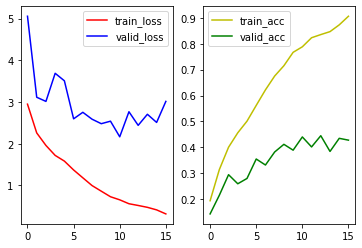

Epoch 16/299
----------


100%|██████████| 110/110 [00:17<00:00,  6.16it/s]


train Loss: 0.3044 Acc: 0.9065


100%|██████████| 440/440 [01:05<00:00,  6.72it/s]


test Loss: 2.7654 Acc: 0.4443


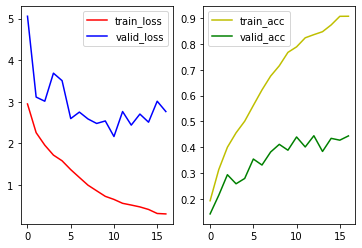

Epoch 17/299
----------


100%|██████████| 110/110 [00:17<00:00,  6.29it/s]


train Loss: 0.2656 Acc: 0.9159


100%|██████████| 440/440 [01:05<00:00,  6.67it/s]


test Loss: 2.9379 Acc: 0.4518


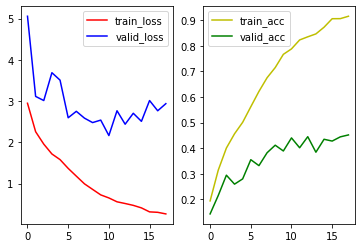

Epoch 18/299
----------


100%|██████████| 110/110 [00:17<00:00,  6.15it/s]


train Loss: 0.2579 Acc: 0.9227


100%|██████████| 440/440 [01:05<00:00,  6.70it/s]


test Loss: 2.8052 Acc: 0.4520


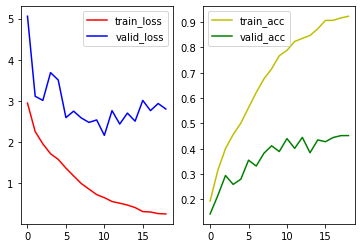

Epoch 19/299
----------


100%|██████████| 110/110 [00:18<00:00,  6.05it/s]


train Loss: 0.2523 Acc: 0.9261


100%|██████████| 440/440 [01:05<00:00,  6.68it/s]


test Loss: 2.6451 Acc: 0.4527


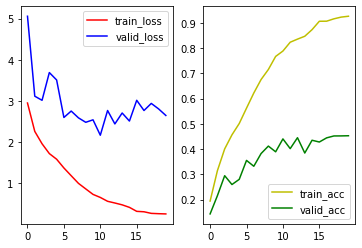

Epoch 20/299
----------


100%|██████████| 110/110 [00:17<00:00,  6.22it/s]


train Loss: 0.1889 Acc: 0.9480


100%|██████████| 440/440 [01:05<00:00,  6.69it/s]


test Loss: 2.9533 Acc: 0.4515


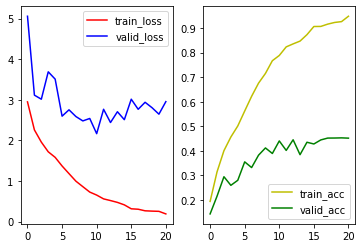

Epoch 21/299
----------


100%|██████████| 110/110 [00:17<00:00,  6.15it/s]


train Loss: 0.1830 Acc: 0.9494


100%|██████████| 440/440 [01:06<00:00,  6.61it/s]


test Loss: 2.6340 Acc: 0.4807


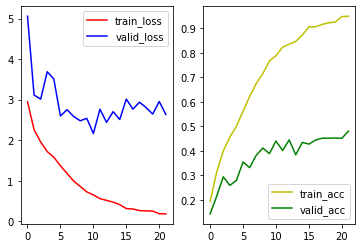

Epoch 22/299
----------


100%|██████████| 110/110 [00:18<00:00,  6.05it/s]


train Loss: 0.1778 Acc: 0.9474


100%|██████████| 440/440 [01:05<00:00,  6.67it/s]


test Loss: 2.6302 Acc: 0.4634


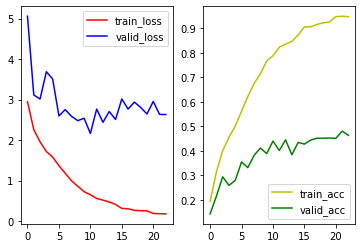

Epoch 23/299
----------


100%|██████████| 110/110 [00:17<00:00,  6.13it/s]


train Loss: 0.2108 Acc: 0.9392


100%|██████████| 440/440 [01:05<00:00,  6.71it/s]


test Loss: 3.2929 Acc: 0.4302


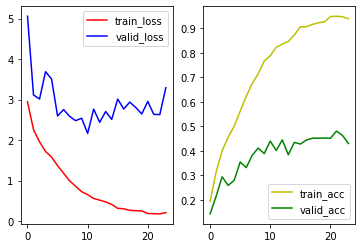

Epoch 24/299
----------


100%|██████████| 110/110 [00:17<00:00,  6.14it/s]


train Loss: 0.2007 Acc: 0.9423


100%|██████████| 440/440 [01:05<00:00,  6.71it/s]


test Loss: 2.4612 Acc: 0.4802


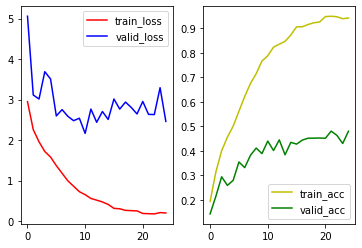

Epoch 25/299
----------


100%|██████████| 110/110 [00:17<00:00,  6.16it/s]


train Loss: 0.1184 Acc: 0.9687


100%|██████████| 440/440 [01:05<00:00,  6.69it/s]


test Loss: 2.6971 Acc: 0.4540


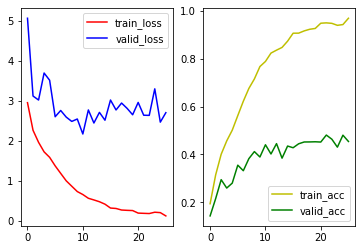

Epoch 26/299
----------


100%|██████████| 110/110 [00:17<00:00,  6.16it/s]


train Loss: 0.1206 Acc: 0.9673


100%|██████████| 440/440 [01:06<00:00,  6.67it/s]


test Loss: 2.8520 Acc: 0.4727


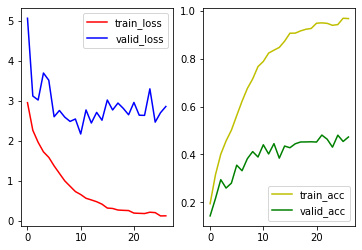

Epoch 27/299
----------


100%|██████████| 110/110 [00:17<00:00,  6.16it/s]


train Loss: 0.1810 Acc: 0.9520


100%|██████████| 440/440 [01:05<00:00,  6.69it/s]


test Loss: 3.1053 Acc: 0.4042


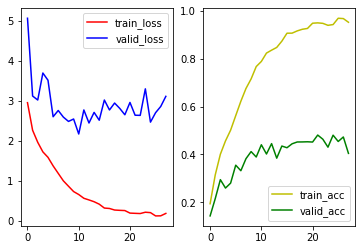

Epoch 28/299
----------


100%|██████████| 110/110 [00:19<00:00,  5.78it/s]


train Loss: 0.2060 Acc: 0.9400


100%|██████████| 440/440 [01:09<00:00,  6.36it/s]


test Loss: 2.7361 Acc: 0.4856


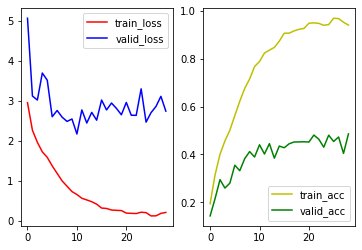

Epoch 29/299
----------


100%|██████████| 110/110 [00:20<00:00,  5.36it/s]


train Loss: 0.1881 Acc: 0.9440


100%|██████████| 440/440 [01:08<00:00,  6.46it/s]


test Loss: 3.2389 Acc: 0.3917


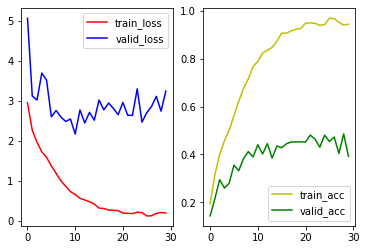

Epoch 30/299
----------


100%|██████████| 110/110 [00:20<00:00,  5.24it/s]


train Loss: 0.1515 Acc: 0.9540


100%|██████████| 440/440 [01:13<00:00,  6.01it/s]


test Loss: 2.6995 Acc: 0.4768


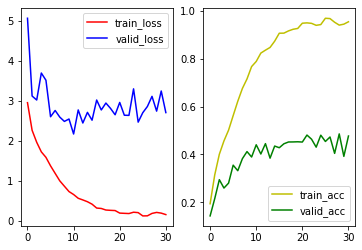

Epoch 31/299
----------


100%|██████████| 110/110 [00:18<00:00,  6.03it/s]


train Loss: 0.1275 Acc: 0.9673


100%|██████████| 440/440 [01:06<00:00,  6.63it/s]


test Loss: 2.7856 Acc: 0.4842


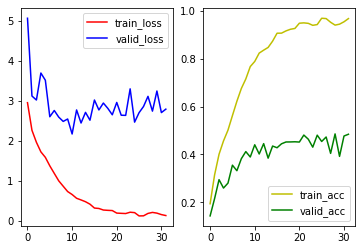

Epoch 32/299
----------


100%|██████████| 110/110 [00:17<00:00,  6.17it/s]


train Loss: 0.0786 Acc: 0.9798


100%|██████████| 440/440 [01:06<00:00,  6.63it/s]


test Loss: 2.8241 Acc: 0.4736


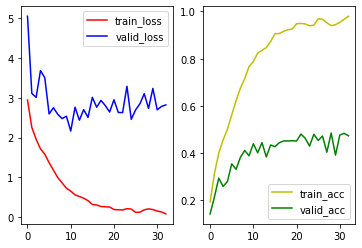

Epoch 33/299
----------


100%|██████████| 110/110 [00:19<00:00,  5.50it/s]


train Loss: 0.0843 Acc: 0.9790


100%|██████████| 440/440 [01:14<00:00,  5.92it/s]


test Loss: 2.6350 Acc: 0.4933


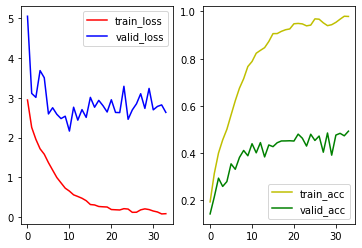

Epoch 34/299
----------


100%|██████████| 110/110 [00:19<00:00,  5.54it/s]


train Loss: 0.0684 Acc: 0.9847


100%|██████████| 440/440 [01:13<00:00,  6.01it/s]


test Loss: 2.4512 Acc: 0.5028


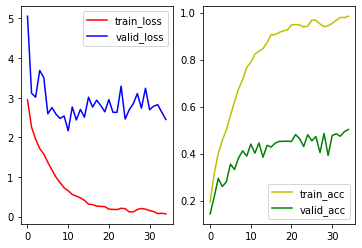

Epoch 35/299
----------


100%|██████████| 110/110 [00:17<00:00,  6.14it/s]


train Loss: 0.0599 Acc: 0.9855


100%|██████████| 440/440 [01:05<00:00,  6.67it/s]


test Loss: 2.6250 Acc: 0.4845


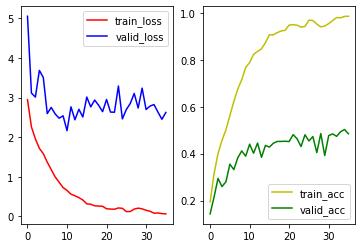

Epoch 36/299
----------


100%|██████████| 110/110 [00:17<00:00,  6.23it/s]


train Loss: 0.0926 Acc: 0.9781


100%|██████████| 440/440 [01:06<00:00,  6.66it/s]


test Loss: 2.6751 Acc: 0.4683


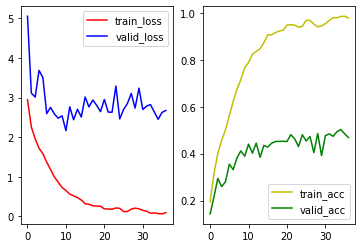

Epoch 37/299
----------


100%|██████████| 110/110 [00:17<00:00,  6.19it/s]


train Loss: 0.2049 Acc: 0.9449


100%|██████████| 440/440 [01:05<00:00,  6.69it/s]


test Loss: 3.0784 Acc: 0.4266


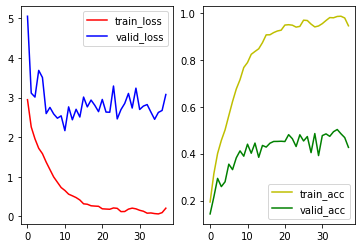

Epoch 38/299
----------


100%|██████████| 110/110 [00:17<00:00,  6.18it/s]


train Loss: 0.2710 Acc: 0.9159


100%|██████████| 440/440 [01:05<00:00,  6.67it/s]


test Loss: 2.8781 Acc: 0.4220


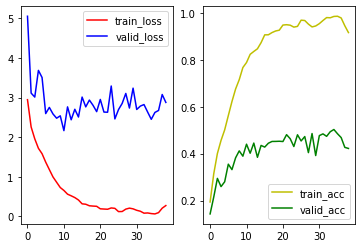

Epoch 39/299
----------


 94%|█████████▎| 103/110 [00:16<00:01,  6.21it/s]


KeyboardInterrupt: 

In [13]:
model_ft, loss_metrics, acc_metrics = train(model_ft, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=epochs)

In [13]:
torch.save(model_ft.state_dict(), './ysq_500.pt')

In [19]:
def confusion_matrix(model, class_num, dataloader):
    cmt = torch.zeros(class_num, class_num, dtype=torch.int64)
    targets = []
    all_preds = []
    with torch.no_grad():
        for images, labels in dataloader:

            model.to(device)
            
            images = images.to(device)
            labels = labels.to(device)
            
            output = model(images)
            _, preds = torch.max(output, 1)
            
            
            preds = preds.data.cpu().numpy()
            labels = labels.data.cpu().numpy()
            
#             print(preds)
    
            targets = np.concatenate((targets, labels), axis = 0)
            all_preds = np.concatenate((all_preds, preds), axis = 0)
            
#             print(targets)
#         stacked = torch.stack((targets, all_preds.argmax(dim=1)), dim=1)
            stacked = np.stack((targets, all_preds), axis=1).astype(int)
#             print(stacked)

        for p in stacked:
            tl, pl = p.tolist()
            cmt[tl, pl] = cmt[tl, pl] + 1
    return cmt

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm.shape)
    plt.figure(figsize=(15, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in (range(cm.shape[0])):
        for j in (range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig("./ysqconfusion_500.png")

In [20]:
cmt = confusion_matrix(model_test, num_classes, dataloaders['test'])

Confusion matrix, without normalization
torch.Size([34, 34])


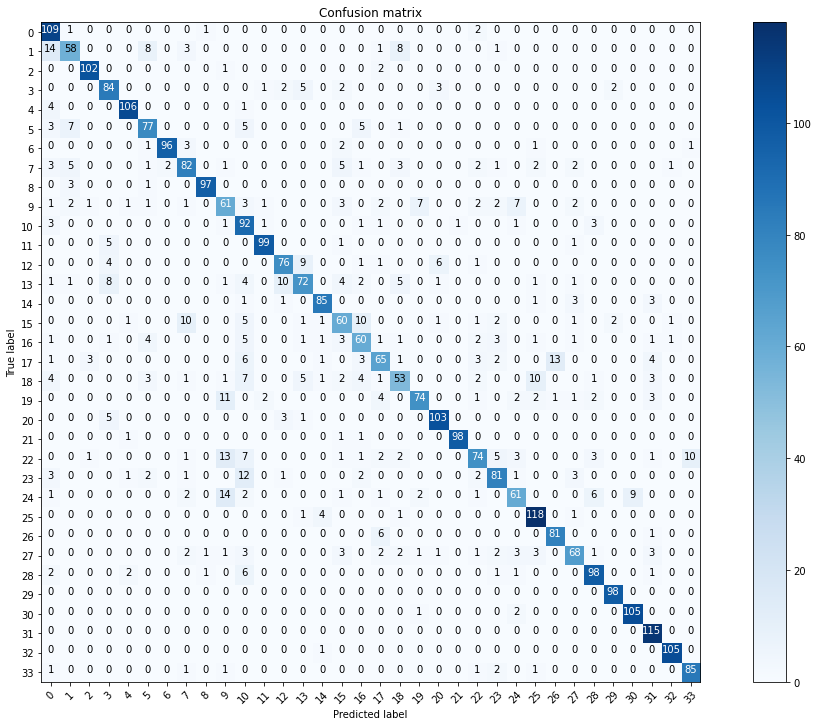

In [21]:
classes = np.arange(0, num_classes)
a = np.arange(0, num_classes)
plot_confusion_matrix(cmt, a)

In [11]:
def test(model, criterion):
    since = time.time()
    
    model.eval()

    predlist=torch.zeros(0,dtype=torch.long, device='cpu')
    lbllist=torch.zeros(0,dtype=torch.long, device='cpu')
            
    running_loss = 0.0
    running_corrects = 0
            
    for inputs, labels in tqdm(dataloaders['test']):
        inputs = inputs.to(device)
        labels = labels.to(device)
                

        outputs = model(inputs)
        _, preds = torch.max(outputs, dim=1)
        loss = criterion(outputs, labels)                        

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

        predlist=torch.cat([predlist,preds.view(-1).cpu()])
        lbllist=torch.cat([lbllist,labels.view(-1).cpu()])
            
    epoch_loss = running_loss / dataset_sizes['test']
    epoch_acc = running_corrects.double() / dataset_sizes['test']
            
    print('{} Loss: {:.4f} Acc: {:.4f}'.format('test', epoch_loss, epoch_acc))
            
        
    time_elapsed = time.time() - since

    return predlist, lbllist

In [9]:
# if needed to laod the models
num_classes = 34
model_test = torchvision.models.resnet18(pretrained=False)

num_ftrs = model_test.fc.in_features
model_test.fc = nn.Linear(num_ftrs, num_classes)
model_test = model_test.to(device)
criterion = nn.CrossEntropyLoss()
model_test.load_state_dict(torch.load('ysq_500.pt'))

<All keys matched successfully>

In [12]:
p, t = test(model_test, criterion)

  1%|          | 1/110 [00:02<04:54,  2.70s/it]


RuntimeError: CUDA out of memory. Tried to allocate 26.00 MiB (GPU 0; 31.75 GiB total capacity; 1.03 GiB already allocated; 25.50 MiB free; 1.09 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [22]:
from sklearn.metrics import precision_recall_fscore_support as score

precision, recall, fscore, support = score(t, p)

avg_p = sum(precision) / len(precision)
avg_r = sum(recall) / len(recall)
avg_f = sum(fscore) / len(fscore)
avg_s = sum(support)

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [0.7218543  0.75324675 0.95327103 0.78504673 0.94642857 0.78571429
 0.97959184 0.76635514 0.97       0.5754717  0.57861635 0.95192308
 0.8172043  0.75789474 0.90425532 0.68181818 0.65934066 0.73033708
 0.68831169 0.87058824 0.89565217 0.98989899 0.77894737 0.79411765
 0.75308642 0.84285714 0.85263158 0.80952381 0.85964912 0.96078431
 0.92105263 0.85185185 0.97222222 0.88541667]
recall: [0.96460177 0.62365591 0.97142857 0.84848485 0.95495495 0.78571429
 0.92307692 0.73873874 0.96039604 0.62886598 0.88461538 0.93396226
 0.7755102  0.64864865 0.90425532 0.625      0.68965517 0.6372549
 0.54081633 0.7184466  0.91964286 0.97029703 0.59677419 0.74311927
 0.61       0.944      0.92045455 0.70103093 0.875      1.
 0.97222222 1.         0.99056604 0.92391304]
fscore: [0.82575758 0.68235294 0.96226415 0.81553398 0.95067265 0.78571429
 0.95049505 0.75229358 0.96517413 0.60098522 0.69961977 0.94285714
 0.79581152 0.69902913 0.90425532 0.65217391 0.6741573  0.68062827
 0.60571429 0.78723

In [2]:
fscore=[0.95223731 ,0.74007937, 0.87109375, 0.7673716,  0.92588832, 0.74493063,
 0.768, 0.64661654, 0.68792711, 0.73869901, 0.58695652, 0.81142857,
 0.76 , 0.39215686, 0.51162791, 0.57142857, 0.61538462, 0.79174484,
 0.77263581, 0.32608696, 0.64073227 ,0.62948207, 0.55530474 ,0.585,
 0.82014388 ,0.14102564, 0.64957265, 0.28947368, 0.64516129 ,0.85,
 0.42857143 ,0.38095238, 0.        ]
ans=sum(fscore)/len(fscore)
print(ans)

0.6241731615151516


In [1]:
import csv
with open("./result.csv", mode='w') as file:
    writer = csv.writer(file, delimiter=",", quotechar='"', quoting=csv.QUOTE_MINIMAL)
    
    writer.writerow(['precision', 'recall', 'fscore', 'support'])
    
    for i in range(len(precision)):
        writer.writerow([precision[i], recall[i], fscore[i], support[i]])
    
    writer.writerow([avg_p, avg_r, avg_f, avg_s])

NameError: name 'precision' is not defined